# Guessing correlations from scatter plots

You may need to install: `imageio`, in Anaconda:

`conda install -c conda-forge imageio`

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

%matplotlib inline

## Loading the data

In [2]:
## Make sure that the data is in the current directory
current_dir = os.getcwd()
train_dir = os.path.join(current_dir, 'data', 'scatters', 'train')
test_dir = os.path.join(current_dir, 'data', 'scatters', 'test')

In [3]:
img_height = 140
img_width = 140

## Training set 
y_train = np.load(os.path.join(train_dir,'train_target.npy'))
n_train = y_train.shape[0]
print("Training examples: ", n_train)
X_train = np.empty(shape=(n_train, img_height, img_width), dtype=np.float)
for i in range(n_train):
    name = 'train_{}.png'.format(i+1)
    X_train[i] = imageio.imread(os.path.join(train_dir, name), pilmode='L')/255.

## Keras expects a rank 4 tensor/array    
X_train = X_train.reshape((n_train, img_height, img_width, 1))

## Testing set
y_test = np.load(os.path.join(test_dir,'test_target.npy'))
n_test = y_test.shape[0]
print("Testing examples: ", n_test)
X_test = np.empty(shape=(n_test, img_height, img_width), dtype=np.float)
for i in range(n_test):
    name = 'test_{}.png'.format(i+1)
    X_test[i] = imageio.imread(os.path.join(test_dir, name), pilmode='L')/255.

X_test = X_test.reshape((n_test, img_height, img_width, 1))

Training examples:  6000
Testing examples:  500


### Sample image

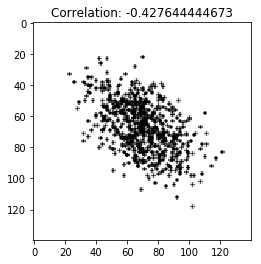

In [4]:
file_suffix = '4'
image_name = 'train_'+ file_suffix + '.png'
image_corr = y_train[int(file_suffix)-1]
sample_img = imageio.imread(os.path.join(train_dir, image_name), pilmode='L')
plt.imshow(-1*sample_img, cmap='Greys')
plt.title('Correlation: ' + str(image_corr));

## Build the CNN network

In [5]:
from keras import layers
from keras import models

Using TensorFlow backend.


In [6]:
model = models.Sequential()
## first pair convolution+max_pooling
model.add(layers.Conv2D(filters=16,
                        kernel_size=(3,3),
                        strides=(1,1),
                        activation='relu',
                        input_shape=(img_height, img_width, 1)))
model.add(layers.MaxPooling2D(pool_size=(4, 4)))

## second pair convolution+max_pooling
model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(4, 4)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(40, activation='relu'))
model.add(layers.Dense(1, activation=None))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 138, 138, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                81960     
__________

## Compile the model

In [7]:
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

## Train the model

In [8]:
model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.1)

Train on 5400 samples, validate on 600 samples
Epoch 1/25
5400/5400 [==============================] - 22s 4ms/step - loss: 0.0853 - mean_squared_error: 0.0853 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 2/25
5400/5400 [==============================] - 20s 4ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 3/25
5400/5400 [==============================] - 20s 4ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 4/25
5400/5400 [==============================] - 20s 4ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 5/25
5400/5400 [==============================] - 20s 4ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/25
5400/5400 [==============================] - 20s 4ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0

## Evaluating results

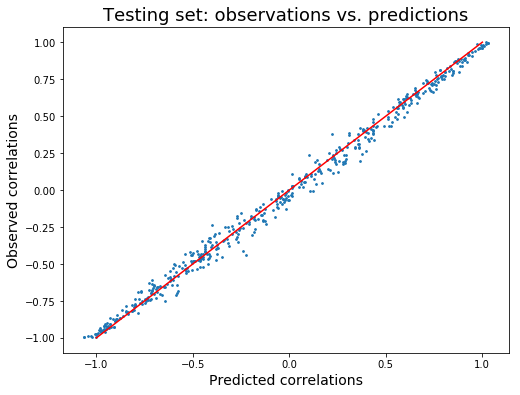

In [9]:
y_pred_test = model.predict(X_test)
fig, ax = plt.subplots(figsize=(8,6))
line_points = np.linspace(-1,1)
ax.plot(line_points, line_points, color='red')
ax.scatter(y_pred_test, y_test, s=3)
ax.set_xlabel('Predicted correlations', size=14)
ax.set_ylabel('Observed correlations', size=14)
ax.set_title('Testing set: observations vs. predictions', size=18);

## Can you beat the model?

#### Try to guess the correlations of the first 10 testing images and then compare your results with the predictions of the model

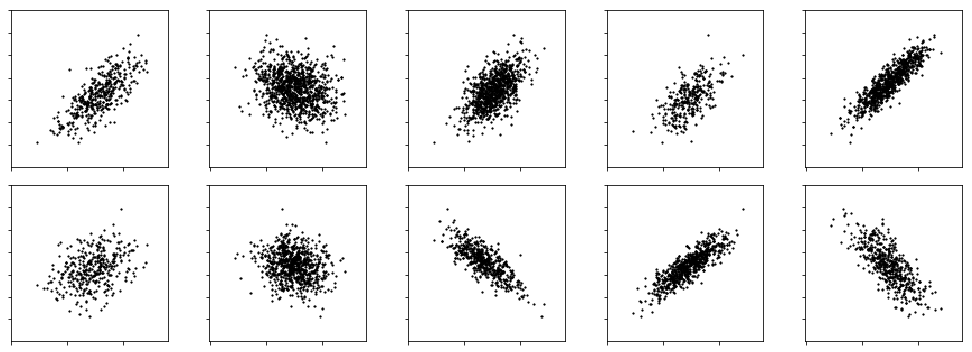

In [18]:
show_results = False
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14,5))
for i, ax in enumerate(axes.flatten()):
    p = X_test[i].reshape(img_height, img_width)
    ax.imshow(-1*p, cmap='Greys')
    if show_results:
        ax.set_title('Pred: ' + str(y_pred_test[i][0]) + '\n ' + 'True: ' + str(y_test[i]))
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
fig.tight_layout()